In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import pytorch_msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
var_1 = pd.read_csv('E:\Programming\Python\Practice\Pytorch\ispdataset.csv')

In [4]:
var_1.shape

(110, 2)

In [5]:
var_1.head()

,short_exposure,medium_exposure
0,short_20161107_232916.jpg,medium_20161107_232916.jpg
1,short_20161107_233033.jpg,medium_20161107_233033.jpg
2,short_20161107_233158.jpg,medium_20161107_233158.jpg
3,short_20161107_233328.jpg,medium_20161107_233328.jpg
4,short_20161107_233444.jpg,medium_20161107_233444.jpg


In [6]:
n = 69
short_img = var_1.iloc[n, 0]
medium_img = var_1.iloc[n, 1]

print('Image name: {}'.format(short_img))
print('Second Image name: {}'.format(medium_img))

Image name: short_20161109_225318.jpg
Second Image name: medium_20161109_225318.jpg


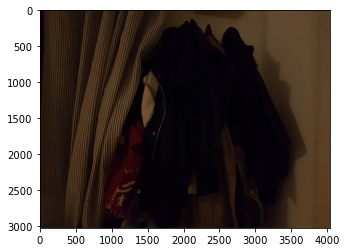

In [7]:
def show_landmarks(image):
    """Show image with landmarks"""
    plt.imshow(image)
    
plt.figure()
show_landmarks(io.imread(os.path.join('E:\Programming\Python\dataset', short_img)))
plt.show()

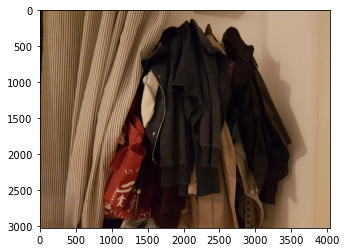

In [8]:
plt.figure()
show_landmarks(io.imread(os.path.join('E:\Programming\Python\dataset', medium_img)))
plt.show()

In [9]:
class DeepISP(Dataset):
    """Deep ISP dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.var_1 = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.var_1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        short_img = os.path.join(self.root_dir,
                                self.var_1.iloc[idx, 0])
        short_image = io.imread(short_img)
        medium_img = os.path.join(self.root_dir,
                                self.var_1.iloc[idx, 1])
        medium_image = io.imread(medium_img)
        sample = {'short_image': short_image, 'medium_image': medium_image}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
S7_dataset = DeepISP(csv_file='E:\Programming\Python\Practice\Pytorch\ispdataset.csv',
                                    root_dir='E:\Programming\Python\dataset')

0 (3024, 4032, 3) (3024, 4032, 3)


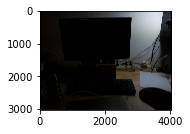

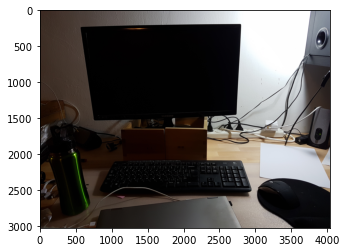

1 (3024, 4032, 3) (3024, 4032, 3)


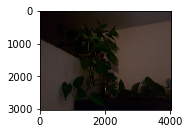

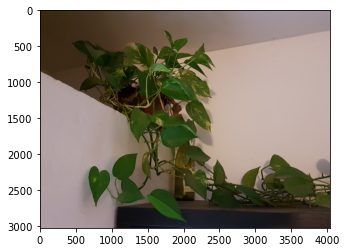

2 (3024, 4032, 3) (3024, 4032, 3)


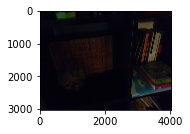

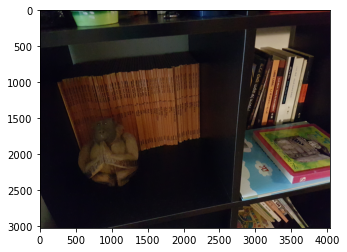

3 (3024, 4032, 3) (3024, 4032, 3)


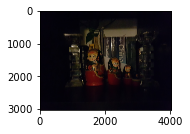

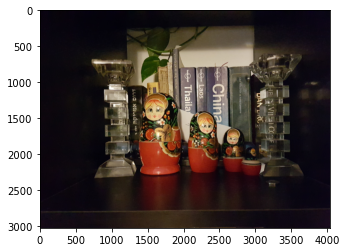

In [11]:
fig = plt.figure()

for i in range(len(S7_dataset)):
    sample = S7_dataset[i]

    print(i, sample['short_image'].shape, sample['medium_image'].shape)

    ax = plt.subplot(2, 2, i + 1)
    #plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    #ax.axis('off')
    show_landmarks(sample['short_image'])
    plt.show()
    show_landmarks(sample['medium_image'])
    plt.show()
    
    if i == 3:
        break

In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        short_image, medium_image = sample['short_image'], sample['medium_image']

        h1, w1 = short_image.shape[:2]
        if isinstance(self.output_size, int):
            if h1 > w1:
                new_h1, new_w1 = self.output_size, self.output_size
            else:
                new_h1, new_w1 = self.output_size, self.output_size
        else:
            new_h1, new_w1 = self.output_size

        new_h1, new_w1 = int(new_h1), int(new_w1)
        
        h2, w2= medium_image.shape[:2]
        if isinstance(self.output_size, int):
            if h2 > w2:
                new_h2, new_w2 = self.output_size, self.output_size
            else:
                new_h2, new_w2 = self.output_size, self.output_size
        else:
            new_h2, new_w2 = self.output_size

        new_h2, new_w2 = int(new_h2), int(new_w2)

        short_img_resize = transform.resize(short_image, (new_h1, new_w1))
        medium_img_resize = transform.resize(medium_image, (new_h2, new_w2))

        return {'short_image': short_img_resize, 'medium_image': medium_img_resize}

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        short_image, medium_image = sample['short_image'], sample['medium_image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        short_image = short_image.transpose((2, 0, 1))
        medium_image = medium_image.transpose((2, 0, 1))
        return {'short_image': torch.from_numpy(short_image),
                'medium_image': torch.from_numpy(medium_image)}

(256, 256, 3)
(256, 256, 3)


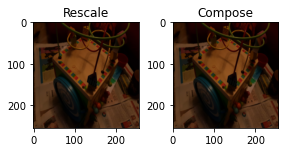

In [14]:
scale = Rescale(256)
composed = transforms.Compose([Rescale(256)])

fig = plt.figure()
sample = S7_dataset[65]
for i, tsfrm in enumerate([scale, composed]):
    transformed_sample = tsfrm(sample)
    print(transformed_sample['medium_image'].shape)
    #print(transformed_sample['short_image'].shape)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(transformed_sample['short_image'])

plt.show()

In [15]:
transformed_S7_dataset = DeepISP(csv_file='E:\Programming\Python\Practice\Pytorch\ispdataset.csv',
                                           root_dir='E:\Programming\Python\dataset',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

In [16]:
batch_size = 8
validation_split = .3
shuffle_dataset = False

dataset_size = len(transformed_S7_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(transformed_S7_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(transformed_S7_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [17]:
class RSNet(nn.Module):
    def __init__(self):
        super(RSNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(5,5), stride=1, padding = 2)
        ##Feature Map 64 256*256
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Feature Map 64 256*256
        ##Upsampling Bilinear
        ##Feature Map 64 512*512
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Feature Map 64 512*512
        self.pool1 = nn.MaxPool2d(kernel_size = (2,2))
        ##Feature Map 64 256*256
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Feature Map 64 256*256
        ##Upsampling Bicubic
        ##Feature Map 64 512*512
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Feature Map 64 512*512
        self.pool2 = nn.MaxPool2d(kernel_size = (2,2))
        ##Feature Map 64 256*256
        self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Feature Map 64 256*256
        self.conv7 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Feature Map 64 256*256
        self.conv8 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), stride=1, padding = 1)
        ##Output
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.interpolate(x, scale_factor = 2.0, mode = 'bilinear')
        x = self.pool1(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.interpolate(x, scale_factor = 2.0, mode = 'bicubic')
        x = self.pool2(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        
        return x

RSCNN = RSNet() 

In [18]:
RSCNN.to(device)

RSNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)